In [232]:
import pandas as pd

titanic_train = pd.read_csv('./datasets/train.csv')

X, y = titanic_train.drop("Survived", axis=1), titanic_train['Survived']

In [233]:
survived = titanic_train[titanic_train['Survived'] == 1]
faked_survivals = survived.sample(abs(y.value_counts()[0] - y.value_counts()[1]))

In [234]:
FABRICATE_DATA = False

if FABRICATE_DATA:
    new_T_data = titanic_train.append(faked_survivals, ignore_index=True)
    X, y = new_T_data.drop("Survived", axis=1), new_T_data['Survived']

In [235]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
import re

def get_title(name):
    title_search = re.search(r'([a-zA-Z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""



class SplitName(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self = self
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.applymap(get_title)
        X = X.replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')        
        X = X.replace('Mlle', 'Miss')
        X = X.replace('Ms', 'Miss')
        X = X.replace('Mme', 'Mrs')
        
        return X

    
class FrequencyImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        #print(type(self.most_frequent_))
        return self
    
    def transform(self, X, y=None):
        #print(self.most_frequent_.keys())
        return X.fillna(self.most_frequent_)
    
    
name_pipeline = Pipeline([
    ('title', SplitName()),
    ('freq_imputer', FrequencyImputer()),
    ('encoder', OneHotEncoder(sparse=True)),
])


In [236]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

cat_pipeline = Pipeline([
    ('freq', FrequencyImputer()),
    ('encoding', OneHotEncoder(sparse=True))
])

num_pipeline = Pipeline([
    ('num_imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())

])

In [237]:
from sklearn.compose import ColumnTransformer

full_pipeline = ColumnTransformer([
    ('tit_pipe', name_pipeline, ['Name']),
    ('cat_atts', cat_pipeline, ['Sex', 'Embarked']),
    ('num_imputer', num_pipeline, ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare'])

])

In [238]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [239]:
prepared_X = full_pipeline.fit_transform(X)

# Testing better models

In [240]:
def get_steps(length, size):
    for i in range(5, length, int(length/size)):
        if i + size > length:
            yield length
        else:
            yield i

In [254]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def plot_learning_curves(model, X, y):
    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    
    for m in get_steps(len(train_X), 100):
        model.fit(train_X[:m], train_y[:m])
        y_train_predict = model.predict(train_X[:m])
        y_val_predict = model.predict(test_X)
        train_errors.append(accuracy_score(train_y[:m], y_train_predict))
        val_errors.append(accuracy_score(test_y, y_val_predict))
    
    plt.plot(train_errors, "r-+", linewidth=2, label="train")
    plt.plot(val_errors, "b-", linewidth=3, label="val")
    
    print(val_errors[-1])

0.8603351955307262


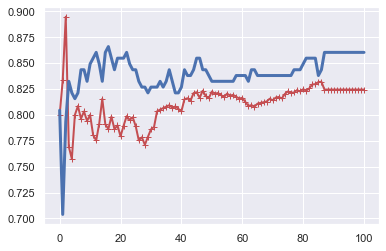

In [242]:
from sklearn.linear_model import LogisticRegression

logistic_clf = LogisticRegression()
plot_learning_curves(logistic_clf, prepared_X, y)

0.8156424581005587


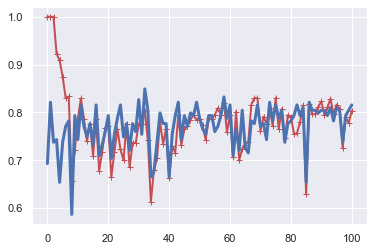

In [243]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier()
plot_learning_curves(sgd_clf, prepared_X, y)

0.8212290502793296


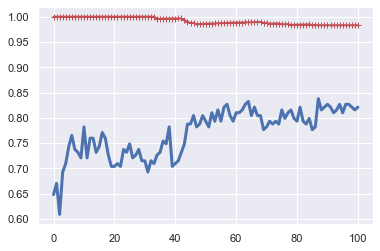

In [244]:
from sklearn.tree import DecisionTreeClassifier

plot_learning_curves(DecisionTreeClassifier(), prepared_X, y)

0.776536312849162


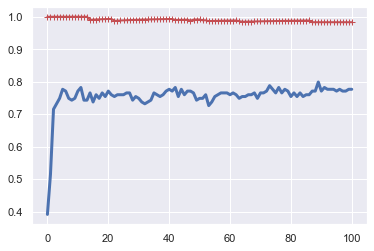

In [245]:
from sklearn.ensemble import RandomForestClassifier

plot_learning_curves(RandomForestClassifier(n_estimators=100), prepared_X, y)

0.8659217877094972


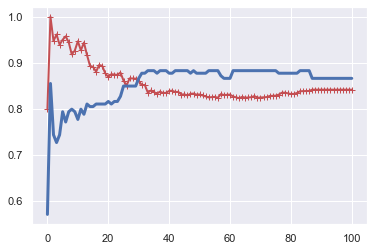

In [246]:
from sklearn.svm import SVC

plot_learning_curves(SVC(), prepared_X, y)

0.8044692737430168


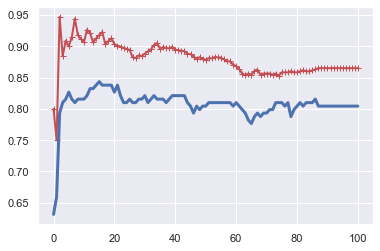

In [247]:
from sklearn.neighbors import KNeighborsClassifier

plot_learning_curves(KNeighborsClassifier(n_neighbors=5), prepared_X, y)

In [248]:
import xgboost as xgb

param = {
    'max_depth': 1,
    'eta':0.3,
    'objective':'multi:softmax',
    'num_class':3,
}
epochs = 2

def xgboost_learning_curve(X, y):
    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    test = xgb.DMatrix(test_X, test_y)

    for m in get_steps(len(train_X), 100):
        train = xgb.DMatrix(train_X[:m], label=train_y[:m])
        model = xgb.train(param, train, epochs)
        y_train_predict = model.predict(train)
        y_val_predict = model.predict(test)
        train_errors.append(accuracy_score(train_y[:m], y_train_predict))
        val_errors.append(accuracy_score(test_y, y_val_predict))

    plt.plot(train_errors, "r-+", linewidth=2, label="train")
    plt.plot(val_errors, "b-", linewidth=3, label="val")

    print(val_errors[-1])

0.770949720670391


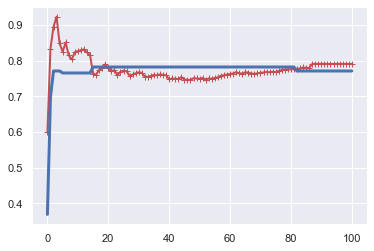

In [249]:
xgboost_learning_curve(prepared_X, y)

# Creating ensemble model based on previous

In [264]:
from sklearn.ensemble import VotingClassifier

ensclf = VotingClassifier(estimators=[
    ('log', logistic_clf), ('sgd', sgd_clf), ('svm', SVC()), ('knn', KNeighborsClassifier(n_neighbors=5))
])# voting='soft', weights=[.81, .83, .84, .82], flatten_transform=True)

0.8324022346368715


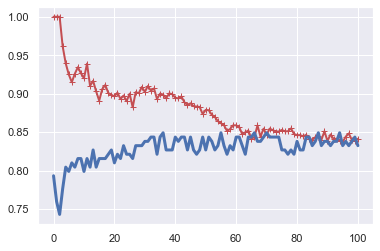

In [265]:
plot_learning_curves(ensclf, prepared_X, y)

# Visualizing Data

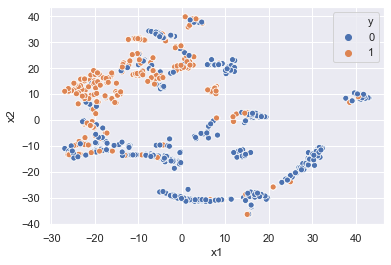

In [257]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

reduced_X = TSNE(n_components=2, random_state=420).fit_transform(prepared_X)

reduced_data = pd.DataFrame(reduced_X, columns=['x1', 'x2'])
reduced_data['y'] = y
sns.scatterplot(x='x1', y='x2', hue='y', data=reduced_data)

# Predicting on test data

In [258]:
import pandas as pd

titanic_test = pd.read_csv('./datasets/test.csv')

In [260]:
prepared_titanic_test = full_pipeline.fit_transform(titanic_test)

In [266]:
ensclf.fit(prepared_X, y)

VotingClassifier(estimators=[('log',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('sgd',
                              SGDClassifier(alpha=0.0001, average=False,
                                            class_weight=None,
                                            early_stopp...
                                  decision_function_shape

In [267]:
ensclf.score(prepared_X, y)

0.8540965207631874

In [268]:
predicted_survivals = ensclf.predict(prepared_titanic_test)
final_titanic_data = titanic_test[["PassengerId"]]
final_titanic_data = pd.DataFrame.from_dict(final_titanic_data)
final_titanic_data["Survived"] = predicted_survivals
final_titanic_data


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [269]:
final_titanic_data.to_csv('submission_v3.csv', index=False)